# Import Libraries

In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold,  cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE

from sklearn.metrics import recall_score
import shap


# Import Data

In [25]:
app_test = pd.read_csv('app_test.csv')
app_train = pd.read_csv('app_train.csv')
prev_app = pd.read_csv('prev_app.csv')
installment_payment = pd.read_csv('installment_payment.csv')

In [26]:
#Drop unused columns
app_train = app_train.drop('Unnamed: 0', axis=1)
prev_app = prev_app.drop('Unnamed: 0', axis=1)
installment_payment = installment_payment.drop('Unnamed: 0', axis=1)

# Clean Data

### app_train

In [27]:
# Drop EXT_SCORE
app_train = app_train.drop(['EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3'], axis=1)
app_train.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction


In [28]:
# Change datatype

app_train[app_train.select_dtypes('object').columns]=app_train.select_dtypes('object').astype('category')

app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LN_ID              61503 non-null  int64   
 1   TARGET             61503 non-null  int64   
 2   CONTRACT_TYPE      61503 non-null  category
 3   GENDER             61503 non-null  category
 4   NUM_CHILDREN       61503 non-null  int64   
 5   INCOME             61503 non-null  float64 
 6   APPROVED_CREDIT    61503 non-null  float64 
 7   ANNUITY            61502 non-null  float64 
 8   PRICE              61441 non-null  float64 
 9   INCOME_TYPE        61503 non-null  category
 10  EDUCATION          61503 non-null  category
 11  FAMILY_STATUS      61503 non-null  category
 12  HOUSING_TYPE       61503 non-null  category
 13  DAYS_AGE           61503 non-null  int64   
 14  DAYS_WORK          61503 non-null  int64   
 15  DAYS_REGISTRATION  61503 non-null  float64 
 16  DAYS

In [29]:
# Check missing values

app_train.isna().sum()

# ANNUITY will be dropped 1 row

LN_ID                 0
TARGET                0
CONTRACT_TYPE         0
GENDER                0
NUM_CHILDREN          0
INCOME                0
APPROVED_CREDIT       0
ANNUITY               1
PRICE                62
INCOME_TYPE           0
EDUCATION             0
FAMILY_STATUS         0
HOUSING_TYPE          0
DAYS_AGE              0
DAYS_WORK             0
DAYS_REGISTRATION     0
DAYS_ID_CHANGE        0
WEEKDAYS_APPLY        0
HOUR_APPLY            0
ORGANIZATION_TYPE     0
dtype: int64

In [30]:
# Fill missing value with 0
app_train['ANNUITY'] = app_train['ANNUITY'].fillna(0)

app_train.isna().sum()

LN_ID                 0
TARGET                0
CONTRACT_TYPE         0
GENDER                0
NUM_CHILDREN          0
INCOME                0
APPROVED_CREDIT       0
ANNUITY               0
PRICE                62
INCOME_TYPE           0
EDUCATION             0
FAMILY_STATUS         0
HOUSING_TYPE          0
DAYS_AGE              0
DAYS_WORK             0
DAYS_REGISTRATION     0
DAYS_ID_CHANGE        0
WEEKDAYS_APPLY        0
HOUR_APPLY            0
ORGANIZATION_TYPE     0
dtype: int64

In [31]:
# Missing values on price because of Revolving loans, thus change to 0
app_train[app_train['PRICE'].isna()]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
722,327096,0,Revolving loans,F,0,125550.0,225000.0,11250.0,NaN,Working,Secondary / secondary special,Married,House / apartment,-18481,-3008,-5450.0,-2026,SATURDAY,13,Electricity
1448,274382,0,Revolving loans,M,0,180000.0,270000.0,13500.0,NaN,Working,Secondary / secondary special,Single / not married,With parents,-10275,-1937,-4103.0,-2946,THURSDAY,17,Other
1509,294934,0,Revolving loans,M,1,202500.0,202500.0,10125.0,NaN,Working,Secondary / secondary special,Married,Municipal apartment,-10212,-2294,-67.0,-2868,SATURDAY,12,Industry: type 9
4378,284082,0,Revolving loans,F,0,247500.0,405000.0,20250.0,NaN,Commercial associate,Higher education,Married,House / apartment,-10867,-286,-5510.0,-3475,THURSDAY,12,Business Entity Type 2
5267,287492,0,Revolving loans,F,0,67500.0,135000.0,6750.0,NaN,Pensioner,Secondary / secondary special,Married,House / apartment,-22374,365243,-4751.0,-4816,WEDNESDAY,10,NA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56644,170764,0,Revolving loans,F,1,112500.0,202500.0,10125.0,NaN,Commercial associate,Secondary / secondary special,Single / not married,With parents,-11412,-1147,-9431.0,-3379,THURSDAY,11,Self-employed
57530,422096,0,Revolving loans,F,1,90000.0,202500.0,10125.0,NaN,Working,Secondary / secondary special,Married,House / apartment,-7950,-1068,-116.0,-577,SATURDAY,14,Other
58776,107822,0,Revolving loans,F,1,121500.0,180000.0,9000.0,NaN,Working,Secondary / secondary special,Civil marriage,House / apartment,-11079,-899,-3765.0,-572,WEDNESDAY,11,Government
58803,295417,0,Revolving loans,F,1,67500.0,180000.0,9000.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,-8141,-592,-6985.0,-812,TUESDAY,9,Restaurant


In [32]:
# Fill missing values with 0
app_train['PRICE'] = app_train['PRICE'].fillna(0)

app_train.isna().sum()

LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
dtype: int64

In [33]:
# Check strange values

for i in range(len(app_train.select_dtypes('category').columns)):
    display(app_train[app_train.select_dtypes('category').columns[i]].value_counts())


Cash loans         55699
Revolving loans     5804
Name: CONTRACT_TYPE, dtype: int64

F    40549
M    20954
Name: GENDER, dtype: int64

Working                 31621
Commercial associate    14217
Pensioner               11249
State servant            4407
Unemployed                  5
Student                     3
Businessman                 1
Name: INCOME_TYPE, dtype: int64

Secondary / secondary special    43777
Higher education                 14887
Incomplete higher                 2045
Lower secondary                    760
Academic degree                     34
Name: EDUCATION, dtype: int64

Married                 39370
Single / not married     9029
Civil marriage           5881
Separated                3970
Widow                    3253
Name: FAMILY_STATUS, dtype: int64

House / apartment      54648
With parents            2891
Municipal apartment     2203
Rented apartment         988
Office apartment         534
Co-op apartment          239
Name: HOUSING_TYPE, dtype: int64

TUESDAY      10838
WEDNESDAY    10477
MONDAY       10234
THURSDAY     10011
FRIDAY        9993
SATURDAY      6795
SUNDAY        3155
Name: WEEKDAYS_APPLY, dtype: int64

Business Entity Type 3    13561
NA1                       11253
Self-employed              7700
Other                      3305
Medicine                   2224
Business Entity Type 2     2083
Government                 2045
School                     1787
Trade: type 7              1557
Kindergarten               1388
Construction               1374
Business Entity Type 1     1185
Transport: type 4          1020
Trade: type 3               663
Industry: type 9            660
Industry: type 3            638
Housing                     611
Security                    596
Military                    540
Industry: type 11           533
Bank                        526
Agriculture                 504
Police                      457
Transport: type 2           436
Postal                      413
Security Ministries         399
Trade: type 2               371
Restaurant                  352
University                  311
Services                    301
Industry: type 7            241
Transpor

In [34]:
# Income type businessman will cause an error later on modeling, as this only exist on train set. The row contain this type will be dropped (1 row)

app_train = app_train.drop(index=app_train.index[app_train['INCOME_TYPE']=='Businessman'])

app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61502 entries, 0 to 61502
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LN_ID              61502 non-null  int64   
 1   TARGET             61502 non-null  int64   
 2   CONTRACT_TYPE      61502 non-null  category
 3   GENDER             61502 non-null  category
 4   NUM_CHILDREN       61502 non-null  int64   
 5   INCOME             61502 non-null  float64 
 6   APPROVED_CREDIT    61502 non-null  float64 
 7   ANNUITY            61502 non-null  float64 
 8   PRICE              61502 non-null  float64 
 9   INCOME_TYPE        61502 non-null  category
 10  EDUCATION          61502 non-null  category
 11  FAMILY_STATUS      61502 non-null  category
 12  HOUSING_TYPE       61502 non-null  category
 13  DAYS_AGE           61502 non-null  int64   
 14  DAYS_WORK          61502 non-null  int64   
 15  DAYS_REGISTRATION  61502 non-null  float64 
 16  DAYS

In [35]:
# Change NA1 in ORGANIZATION_TYPE to Unkonwn

app_train['ORGANIZATION_TYPE'] = app_train['ORGANIZATION_TYPE'].str.replace("NA1","Unknown")


In [36]:
#Check Duplicated value
app_train[app_train.duplicated()]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [37]:
# Change Age from days to year

app_train['YEAR_AGE'] = app_train.apply(lambda x: x['DAYS_AGE']/-365, axis=1)

app_train.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,...,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,YEAR_AGE
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,31.613699
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,...,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,43.131507
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,...,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,Unknown,56.917808
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,...,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,56.600000
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,...,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,24.693151


### app_test

In [38]:
# Create function for cleaning app_test, as it have the same columns and data types with app_train
def wrangle(df):
    df.drop(['EXT_SCORE_1','EXT_SCORE_2','EXT_SCORE_3'],axis=1,inplace=True)
    df['ANNUITY']=df['ANNUITY'].fillna(0)
    df[df.select_dtypes('object').columns]=df.select_dtypes('object').astype('category')
    df['ORGANIZATION_TYPE']=df['ORGANIZATION_TYPE'].str.replace("NA1","Unknown")
    return df

In [39]:
wrangle(app_test)

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411,-1131,SATURDAY,7,Business Entity Type 3
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908,-4872,MONDAY,14,Kindergarten
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226,-1930,SATURDAY,12,Self-employed
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916,-4048,THURSDAY,13,Other
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640,-2035,MONDAY,14,Business Entity Type 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14756,144293,0,Cash loans,F,1,67500.0,112500.0,7317.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-12866,-3154,-1251,-4395,TUESDAY,10,Government
14757,272093,1,Cash loans,F,1,135000.0,313438.5,21073.5,283500.0,Working,Secondary / secondary special,Civil marriage,With parents,-11421,-3962,-5247,-3795,SATURDAY,7,Self-employed
14758,251117,0,Cash loans,F,0,157500.0,1078200.0,31522.5,900000.0,State servant,Higher education,Separated,House / apartment,-13313,-2258,-3899,-4515,MONDAY,12,Other
14759,334313,0,Cash loans,F,0,216000.0,272520.0,21658.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-24085,365243,-9354,-4740,THURSDAY,15,Unknown


In [40]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LN_ID              14761 non-null  int64   
 1   TARGET             14761 non-null  int64   
 2   CONTRACT_TYPE      14761 non-null  category
 3   GENDER             14761 non-null  category
 4   NUM_CHILDREN       14761 non-null  int64   
 5   INCOME             14761 non-null  float64 
 6   APPROVED_CREDIT    14761 non-null  float64 
 7   ANNUITY            14761 non-null  float64 
 8   PRICE              14741 non-null  float64 
 9   INCOME_TYPE        14761 non-null  category
 10  EDUCATION          14761 non-null  category
 11  FAMILY_STATUS      14761 non-null  category
 12  HOUSING_TYPE       14761 non-null  category
 13  DAYS_AGE           14761 non-null  int64   
 14  DAYS_WORK          14761 non-null  int64   
 15  DAYS_REGISTRATION  14761 non-null  int64   
 16  DAYS

In [41]:
# Fill missing value with 0
app_test['PRICE'] = app_test['PRICE'].fillna(0)

app_test.isna().sum()

LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
dtype: int64

In [42]:
#Check Duplicated value
app_test[app_test.duplicated()]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [43]:
# Change Age from days to year

app_test['YEAR_AGE'] = app_test.apply(lambda x: x['DAYS_AGE']/-365, axis=1)

app_test.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,...,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,YEAR_AGE
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,...,Married,House / apartment,-17598,-2650,-1411,-1131,SATURDAY,7,Business Entity Type 3,48.213699
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,...,Married,Office apartment,-14097,-7408,-7908,-4872,MONDAY,14,Kindergarten,38.621918
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,...,Married,House / apartment,-18384,-2826,-8226,-1930,SATURDAY,12,Self-employed,50.367123
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,...,Married,House / apartment,-12170,-926,-916,-4048,THURSDAY,13,Other,33.342466
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,...,Married,House / apartment,-10790,-577,-4640,-2035,MONDAY,14,Business Entity Type 3,29.561644


In [44]:
# Check strange values

for i in range(len(app_test.select_dtypes('category').columns)):
    display(app_test[app_test.select_dtypes('category').columns[i]].value_counts())

Cash loans         13281
Revolving loans     1480
Name: CONTRACT_TYPE, dtype: int64

F    9685
M    5076
Name: GENDER, dtype: int64

Working                 7571
Commercial associate    3427
Pensioner               2726
State servant           1036
Unemployed                 1
Name: INCOME_TYPE, dtype: int64

Secondary / secondary special    10431
Higher education                  3615
Incomplete higher                  500
Lower secondary                    208
Academic degree                      7
Name: EDUCATION, dtype: int64

Married                 9539
Single / not married    2084
Civil marriage          1441
Separated                937
Widow                    760
Name: FAMILY_STATUS, dtype: int64

House / apartment      13135
With parents             697
Municipal apartment      531
Rented apartment         218
Office apartment         128
Co-op apartment           52
Name: HOUSING_TYPE, dtype: int64

TUESDAY      2601
WEDNESDAY    2571
FRIDAY       2417
THURSDAY     2380
MONDAY       2375
SATURDAY     1653
SUNDAY        764
Name: WEEKDAYS_APPLY, dtype: int64

### prev_app

In [45]:
prev_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350712 entries, 0 to 350711
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 350712 non-null  int64  
 1   LN_ID                      350712 non-null  int64  
 2   CONTRACT_TYPE              350712 non-null  object 
 3   ANNUITY                    274103 non-null  float64
 4   APPLICATION                350712 non-null  float64
 5   APPROVED_CREDIT            350712 non-null  float64
 6   AMT_DOWN_PAYMENT           164205 non-null  float64
 7   PRICE                      271072 non-null  float64
 8   WEEKDAYS_APPLY             350712 non-null  object 
 9   HOUR_APPLY                 350712 non-null  int64  
 10  CONTRACT_STATUS            350712 non-null  object 
 11  DAYS_DECISION              350712 non-null  int64  
 12  TERM_PAYMENT               274103 non-null  float64
 13  YIELD_GROUP                35

In [46]:
prev_app.isna().sum()

SK_ID_PREV                        0
LN_ID                             0
CONTRACT_TYPE                     0
ANNUITY                       76609
APPLICATION                       0
APPROVED_CREDIT                   0
AMT_DOWN_PAYMENT             186507
PRICE                         79640
WEEKDAYS_APPLY                    0
HOUR_APPLY                        0
CONTRACT_STATUS                   0
DAYS_DECISION                     0
TERM_PAYMENT                  76609
YIELD_GROUP                       0
FIRST_DRAW                   139305
FIRST_DUE                    139305
TERMINATION                  139305
NFLAG_INSURED_ON_APPROVAL    139305
dtype: int64

In [47]:
# Missing values in numerical columns will be replaced with 0

prev_app = prev_app.fillna(0)

prev_app.isna().sum()

SK_ID_PREV                   0
LN_ID                        0
CONTRACT_TYPE                0
ANNUITY                      0
APPLICATION                  0
APPROVED_CREDIT              0
AMT_DOWN_PAYMENT             0
PRICE                        0
WEEKDAYS_APPLY               0
HOUR_APPLY                   0
CONTRACT_STATUS              0
DAYS_DECISION                0
TERM_PAYMENT                 0
YIELD_GROUP                  0
FIRST_DRAW                   0
FIRST_DUE                    0
TERMINATION                  0
NFLAG_INSURED_ON_APPROVAL    0
dtype: int64

In [48]:
#Check Duplicated value
prev_app[prev_app.duplicated()]

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL


In [49]:
# Check strange values

for i in range(len(prev_app.select_dtypes('object').columns)):
    display(prev_app[prev_app.select_dtypes('object').columns[i]].value_counts())
    


Cash loans         155822
Consumer loans     154684
Revolving loans     40131
NA1                    75
Name: CONTRACT_TYPE, dtype: int64

TUESDAY      53694
WEDNESDAY    53679
MONDAY       53185
FRIDAY       52771
THURSDAY     52125
SATURDAY     50687
SUNDAY       34571
Name: WEEKDAYS_APPLY, dtype: int64

Approved        219687
Canceled         64590
Refused          60795
Unused offer      5640
Name: CONTRACT_STATUS, dtype: int64

NA1           106872
middle         80248
high           76040
low_normal     68163
low_action     19389
Name: YIELD_GROUP, dtype: int64

### installment_payment

In [50]:
installment_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872306 entries, 0 to 2872305
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SK_ID_PREV   int64  
 1   LN_ID        int64  
 2   INST_NUMBER  int64  
 3   INST_DAYS    float64
 4   PAY_DAYS     float64
 5   AMT_INST     float64
 6   AMT_PAY      float64
dtypes: float64(4), int64(3)
memory usage: 153.4 MB


In [51]:
installment_payment.isna().sum()

SK_ID_PREV       0
LN_ID            0
INST_NUMBER      0
INST_DAYS        0
PAY_DAYS       673
AMT_INST         0
AMT_PAY        673
dtype: int64

In [52]:
# Missing values in numerical columns will be replaced with 0

installment_payment = installment_payment.fillna(0)

installment_payment.isna().sum()

SK_ID_PREV     0
LN_ID          0
INST_NUMBER    0
INST_DAYS      0
PAY_DAYS       0
AMT_INST       0
AMT_PAY        0
dtype: int64

In [53]:
#Check Duplicated value
installment_payment[installment_payment.duplicated()]

,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
261880,1604926,164271,3,-388.0,-405.0,2610.000,5220.00
556029,1853107,111076,4,-692.0,-719.0,30558.420,61116.84
1561590,2174624,327438,14,-557.0,-560.0,11657.880,23315.76
1632523,1377916,345775,5,-92.0,-95.0,35100.000,70200.00
1641072,1669001,336526,2,-327.0,-340.0,19230.930,38461.86
1942034,1377916,345775,3,-152.0,-156.0,36292.500,72585.00
2133461,1061066,416815,4,-327.0,-339.0,19724.355,39448.71
2274944,2585538,436164,2,-599.0,-628.0,22236.840,44473.68


In [54]:
# Drop duplicated values
installment_payment.drop_duplicates(inplace=True)

# Feature Engineering

## installment_payment

In [55]:
# We want to know if the customer is a late payer or not (subtract installment days with pay days)
installment_payment['INST-PAY'] = installment_payment.apply(lambda x: x['INST_DAYS']-x['PAY_DAYS'], axis=1)

installment_payment.head()

,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,INST-PAY
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375,33.0
1,2723183,112102,14,-197.0,-197.0,70.740,70.740,0.0
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080,7.0
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450,11.0
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000,13.0


In [56]:
installment_payment['LATE'] = installment_payment['INST-PAY'].apply(lambda x: 'LATE' if x < 0 else ('EARLY' if x > 0 else 'ON-TIME'))

installment_payment.head()

,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,INST-PAY,LATE
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375,33.0,EARLY
1,2723183,112102,14,-197.0,-197.0,70.740,70.740,0.0,ON-TIME
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080,7.0,EARLY
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450,11.0,EARLY
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000,13.0,EARLY


In [57]:
# Create new dataframe with information on customer's payment behaviour 
df_behav=installment_payment.groupby(['LN_ID'])['LATE'].value_counts(normalize=True).to_frame().rename({"LATE":"%"},axis=1).reset_index().sort_values('%', ascending=False).groupby('LN_ID').head(1).rename({"LATE":"Inst-Behav"},axis=1)

df_behav

,LN_ID,Inst-Behav,%
31909,175358,EARLY,1.000000
93684,320713,EARLY,1.000000
93691,320731,EARLY,1.000000
53287,226310,EARLY,1.000000
93706,320770,EARLY,1.000000
...,...,...,...
45339,207078,EARLY,0.333333
12188,129087,ON-TIME,0.333333
118644,378841,EARLY,0.333333
20388,147820,EARLY,0.333333


## prev_app

In [58]:
prev_app

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.0,340573.5,0.0,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,2315218,175704,Cash loans,0.000,0.0,0.0,0.0,0.0,TUESDAY,11,Canceled,-14,0.0,NA1,0.0,0.0,0.0,0.0
4,1715995,447712,Cash loans,11368.620,270000.0,335754.0,0.0,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350707,1379569,309506,Cash loans,33389.100,1035000.0,1035000.0,0.0,1035000.0,THURSDAY,10,Refused,-156,60.0,low_normal,0.0,0.0,0.0,0.0
350708,1252861,363895,Cash loans,56754.000,1350000.0,1350000.0,0.0,1350000.0,THURSDAY,16,Refused,-847,48.0,middle,0.0,0.0,0.0,0.0
350709,1379406,302265,Cash loans,0.000,0.0,0.0,0.0,0.0,WEDNESDAY,13,Canceled,-502,0.0,NA1,0.0,0.0,0.0,0.0
350710,2698899,161204,Cash loans,0.000,0.0,0.0,0.0,0.0,SATURDAY,13,Canceled,-359,0.0,NA1,0.0,0.0,0.0,0.0


In [59]:
# We want to know if the approval rate of the loan application
df_attempt=prev_app.groupby(['LN_ID','CONTRACT_STATUS'],as_index=False).count()[['LN_ID','SK_ID_PREV','CONTRACT_STATUS']].rename({'SK_ID_PREV':'Loan Application Attempt'},axis=1).groupby('LN_ID')['CONTRACT_STATUS'].value_counts(normalize=True).to_frame().rename({"CONTRACT_STATUS":"Approval Rate"},axis=1).reset_index()

df_attempt

,LN_ID,CONTRACT_STATUS,Approval Rate
0,100009,Approved,1.0
1,100039,Approved,0.5
2,100039,Canceled,0.5
3,100044,Approved,1.0
4,100045,Approved,1.0
...,...,...,...
129103,456249,Approved,0.5
129104,456249,Refused,0.5
129105,456252,Approved,1.0
129106,456255,Approved,0.5


In [60]:
# Filter only the approved loan
df_attempt2=df_attempt[df_attempt['CONTRACT_STATUS']=="Approved"][['LN_ID',"Approval Rate"]]
df_attempt2

,LN_ID,Approval Rate
0,100009,1.0
1,100039,0.5
3,100044,1.0
4,100045,1.0
5,100046,0.5
...,...,...
129100,456247,0.5
129102,456248,1.0
129103,456249,0.5
129105,456252,1.0


## Merge

In [61]:
df_features=pd.merge(df_behav,df_attempt2,how="outer").drop('%',axis=1)
df_features

,LN_ID,Inst-Behav,Approval Rate
0,175358,EARLY,0.5
1,320713,EARLY,0.5
2,320731,EARLY,1.0
3,226310,EARLY,1.0
4,320770,EARLY,0.5
...,...,...,...
72398,437729,NaN,0.5
72399,440618,NaN,1.0
72400,443497,NaN,0.5
72401,445708,NaN,0.5


In [62]:
# Fill the missing values
df_features['Inst-Behav']=df_features['Inst-Behav'].fillna("Unknown")
df_features['Approval Rate']=df_features['Approval Rate'].fillna(0)

df_features

,LN_ID,Inst-Behav,Approval Rate
0,175358,EARLY,0.5
1,320713,EARLY,0.5
2,320731,EARLY,1.0
3,226310,EARLY,1.0
4,320770,EARLY,0.5
...,...,...,...
72398,437729,Unknown,0.5
72399,440618,Unknown,1.0
72400,443497,Unknown,0.5
72401,445708,Unknown,0.5


In [63]:
# Merge with the app_test dataframe
app_test_new=pd.merge(app_test,df_features,how="left")

In [64]:
# Merge with the app_train dataframe
app_train_new=pd.merge(app_train,df_features,how="left")

In [65]:
# Fill the missing values
app_test_new['Inst-Behav']=app_test_new['Inst-Behav'].fillna("Unknown")
app_test_new['Approval Rate']=app_test_new['Approval Rate'].fillna(0)

In [66]:
# Fill the missing values
app_train_new['Inst-Behav']=app_train_new['Inst-Behav'].fillna("Unknown")
app_train_new['Approval Rate']=app_train_new['Approval Rate'].fillna(0)

In [67]:
#Check missing values
app_train_new.isna().sum()

LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
YEAR_AGE             0
Inst-Behav           0
Approval Rate        0
dtype: int64

In [68]:
# Drop unused columns (DAYS_AGE & ORGANIZATION_TYPE)

app_train_new = app_train_new.drop(['DAYS_AGE','ORGANIZATION_TYPE'], axis=1)
app_test_new = app_test_new.drop(['DAYS_AGE','ORGANIZATION_TYPE'], axis=1)

## Check Multicolinearity

In [69]:
# Check the multicolinearity with threshold 7
def calc_vif(X):
    vif = pd.DataFrame()
    vif['variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    return vif

calc_vif(app_train_new.select_dtypes(include=['int','float']).drop(columns='TARGET'))

,variable,VIF
0,LN_ID,7.209276
1,NUM_CHILDREN,1.466597
2,INCOME,2.981305
3,APPROVED_CREDIT,122.948047
4,ANNUITY,11.686279
5,PRICE,121.294110
6,DAYS_WORK,1.914695
7,DAYS_REGISTRATION,3.386711
8,DAYS_ID_CHANGE,5.421491
9,HOUR_APPLY,10.614008


In [70]:
# Drop column price

app_train_new = app_train_new.drop(['PRICE', 'ANNUITY'], axis=1)
app_test_new = app_test_new.drop(['PRICE','ANNUITY'], axis=1)

calc_vif(app_train_new.select_dtypes(include=['int','float']).drop(columns='TARGET'))

,variable,VIF
0,LN_ID,7.175674
1,NUM_CHILDREN,1.461636
2,INCOME,2.819254
3,APPROVED_CREDIT,3.534353
4,DAYS_WORK,1.900633
5,DAYS_REGISTRATION,3.384952
6,DAYS_ID_CHANGE,5.417841
7,HOUR_APPLY,10.499628
8,YEAR_AGE,18.060556
9,Approval Rate,4.600492


In [71]:
# Convert HOUR_APPLY to category by binning

bins = [0, 5, 13, 17, 25]
labels=['Night','Morning','Afternoon','Evening']
app_train_new['HOUR_BIN'] = pd.cut(app_train_new['HOUR_APPLY'], bins, labels=labels, include_lowest=True)
app_test_new['HOUR_BIN'] = pd.cut(app_test_new['HOUR_APPLY'], bins, labels=labels, include_lowest=True)


In [72]:
# As its still above 7 we will drop column HOUR_APPLY
app_train_new = app_train_new.drop(['HOUR_APPLY'], axis=1)
app_test_new = app_test_new.drop(['HOUR_APPLY'], axis=1)

calc_vif(app_train_new.select_dtypes(include=['int','float']).drop(columns='TARGET'))

,variable,VIF
0,LN_ID,6.722274
1,NUM_CHILDREN,1.445216
2,INCOME,2.768648
3,APPROVED_CREDIT,3.504690
4,DAYS_WORK,1.804655
5,DAYS_REGISTRATION,3.369142
6,DAYS_ID_CHANGE,5.364100
7,YEAR_AGE,15.606050
8,Approval Rate,4.462801


In [73]:
# Drop column YEAR_AGE
app_train_new = app_train_new.drop(['YEAR_AGE'], axis=1)
app_test_new = app_test_new.drop(['YEAR_AGE'], axis=1)

calc_vif(app_train_new.select_dtypes(include=['int','float']).drop(columns='TARGET'))

,variable,VIF
0,LN_ID,5.515272
1,NUM_CHILDREN,1.433599
2,INCOME,2.700096
3,APPROVED_CREDIT,3.286591
4,DAYS_WORK,1.450256
5,DAYS_REGISTRATION,2.946103
6,DAYS_ID_CHANGE,4.655571
7,Approval Rate,4.054729


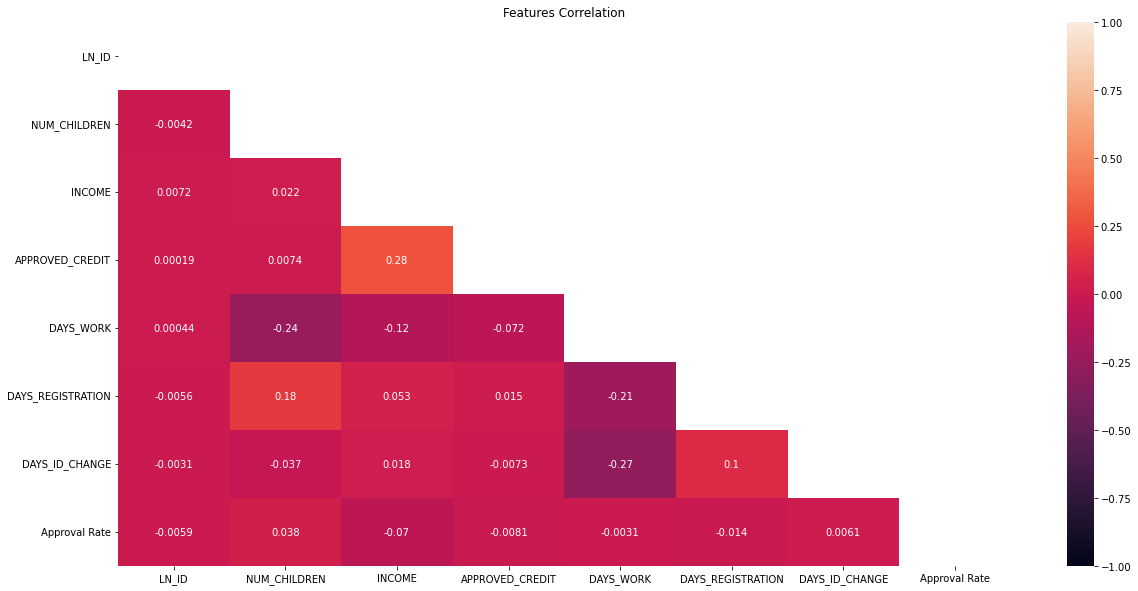

In [74]:
# Last check with heat map
plt.figure(figsize=(20,10))

# Kita buat mask jadi yang terlihat hanya bagian bawah
mask = np.triu(np.ones_like(app_train_new.drop(columns='TARGET').corr(),dtype=bool))

# Heatmap
sns.heatmap(app_train_new.drop(columns='TARGET').corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Features Correlation')
plt.show()

# Preprocess


In [75]:
# Create variable for categorical variables
cat_var = app_train_new.select_dtypes(['category', 'object']).columns

cat_var


Index(['CONTRACT_TYPE', 'GENDER', 'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS',
       'HOUSING_TYPE', 'WEEKDAYS_APPLY', 'Inst-Behav', 'HOUR_BIN'],
      dtype='object')

In [76]:
# Create variable for numerical variables
con_var = app_train_new.select_dtypes(exclude=['category','object']).columns

con_var

Index(['LN_ID', 'TARGET', 'NUM_CHILDREN', 'INCOME', 'APPROVED_CREDIT',
       'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'Approval Rate'],
      dtype='object')

In [77]:
# Define transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_var)
], remainder='passthrough')


# Define X and y
X_train = app_train_new.drop(['TARGET'], axis=1)
y_train = app_train_new['TARGET']

X_test = app_test_new.drop(['TARGET'],axis=1)
y_test = app_test_new['TARGET']

<AxesSubplot:>

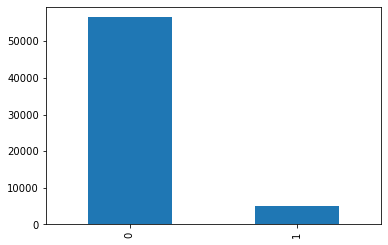

In [78]:
# Check if imbalanced
app_train_new['TARGET'].value_counts().plot(kind='bar')

# Model

In [79]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
adb = AdaBoostClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)
cat = CatBoostClassifier(random_state=0)

scaler = RobustScaler()
smote = SMOTE(random_state=0)

## Metrics

In this case, the positive value is 1 (which means that the customer will be a late payer).
Thus we will focused on the positive and the false positive (customer falsely categorized as a late payer), as we will lose potential customer if its higher

We will use **RECALL** for our metrics because we want to decrease the false positive and focused on detecting the true positive.

In [80]:
# Find benchmark model
models = [logreg, knn, dt, rf, adb, xgb, cat]
score = []
mean = []
std = []

for i in models:
    estimator = Pipeline([
        ('preprocess',transformer),
        ('scale', scaler),
        ('resampler', smote),
        ('model',i)
        ])

    model_cv = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=5,
        scoring='recall')

    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({
    'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'CatBoost'],
    'recall mean':mean,'recall std':std}).set_index('model').sort_values(by='recall mean',ascending=False)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[11:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:47:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:47:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.070522
0:	learn: 0.6537099	total: 154ms	remaining: 2m 33s
1:	learn: 0.6142901	total: 168ms	remaining: 1m 23s
2:	learn: 0.5920026	total: 184ms	remaining: 1m 1s
3:	learn: 0.5722499	total: 198ms	remaining: 49.4s
4:	learn: 0.5575401	total: 212ms	remaining: 42.2s
5:	learn: 0.5263043	total: 228ms	remaining: 37.7s
6:	learn: 0.5120121	total: 244ms	remaining: 34.6s
7:	learn: 0.5012446	total: 257ms	remaining: 31.8s
8:	learn: 0.4805508	total: 270ms	remaining: 29.7s
9:	learn: 0.4729978	total: 283ms	remaining: 28s
10:	learn: 0.4634692	total: 296ms	remaining: 26.6s
11:	learn: 0.4579865	total: 309ms	remaining: 25.4s
12:	learn: 0.4536286	total: 321ms	remaining: 24.4s
13:	lea

,recall mean,recall std
model,,
Logistic Regression,0.602336,0.013978
KNN,0.381571,0.016798
AdaBoost,0.305899,0.012076
Decision Tree,0.149730,0.012931
Random Forest,0.022135,0.007606
XGBoost,0.018113,0.002852
CatBoost,0.014692,0.002076


We have our benchmark model which is Logistic Regression with recall mean 0.60.

In [84]:
# Model before hyperparameter tuning
base_model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('resampler', smote),
        ('model', logreg)
    ])

base_model.fit(X_train, y_train)

y_pred_base = base_model.predict(X_test)

# Check classification report
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74     13558
           1       0.12      0.58      0.20      1203

    accuracy                           0.61     14761
   macro avg       0.53      0.60      0.47     14761
weighted avg       0.88      0.61      0.70     14761



# Hyperparameter Tuning

In [85]:
# Tuning the benchmark model to get better score
logreg = LogisticRegression(random_state=0, max_iter=1000,dual=False)
logreg_pipe = Pipeline([
    ('preprocess', transformer),
    ('scale', scaler),
    ('resampler', smote),
    ('model', logreg)
])

hyperparam_space = {
 'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'model__penalty': ['l1','l2','elasticnet'],
 'model__C': [100,10,1.0,0.1,0.01]
}

# Took too long with gridsearch, thus changed to randomizedsearch
# grid_search = GridSearchCV(
#     estimator=logreg_pipe,
#     param_grid=hyperparam_space,
#     cv=10,
#     scoring='recall'
# )

# # fitting gridsearch
# grid_search.fit(X_train, y_train)


# Randomized Search
random_search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=hyperparam_space,
    cv=5,
    n_iter=60,
    random_state=0,
    scoring='recall'
)

# Fitting random search
random_search.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
lbfgs failed to converge (status=1):
STO

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['CONTRACT_TYPE', 'GENDER', 'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS',
       'HOUSING_TYPE', 'WEEKDAYS_APPLY', 'Inst-Behav', 'HOUR_BIN'],
      dtype='object'))])),
                                             ('scale', RobustScaler()),
                                             ('resampler',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              LogisticRegression(max_iter=1000,
                                        

In [86]:
# The tuning increases the recall score, although not significant
print('Best recall score: ', random_search.best_score_)
print('Best param: ', random_search.best_params_)

Best recall score:  0.6049537912267158
Best param:  {'model__solver': 'newton-cg', 'model__penalty': 'l2', 'model__C': 100}


In [87]:
# Check the classification report after tuning
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75     13558
           1       0.12      0.59      0.20      1203

    accuracy                           0.62     14761
   macro avg       0.53      0.60      0.47     14761
weighted avg       0.88      0.62      0.70     14761



# Feature Importance

In [88]:
# Using the best model to find feature importance (we will not use smote, becase it keeps getting error)
logreg_best = LogisticRegression(random_state=0, max_iter=1000,dual=False, solver='newton-cg',penalty='l2',C=100)

# Encode & Scale manually
X_train_encode = transformer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_encode)

# Fitting the model
logreg_best.fit(X_train_scaled, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=0, solver='newton-cg')

In [89]:
X_train_DF = pd.DataFrame(X_train_scaled)
X_train_DF

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.308837,1.0,-0.90,-0.575414,0.115493,0.798650,0.195291,0.75
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,0.0,0.718019,1.0,0.60,0.861905,-1.317505,0.492614,0.311849,0.00
2,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,0.0,-0.107632,0.0,0.35,-0.194795,147.465191,-0.773117,-0.404863,-0.25
3,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.747980,0.0,0.85,0.549900,-3.721127,-0.091191,-0.288306,0.75
4,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,-0.205979,0.0,-0.15,-0.617185,0.007243,0.177640,0.624855,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61497,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,-0.152247,2.0,2.35,-0.115931,-1.853119,0.398504,0.213817,0.00
61498,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.912418,0.0,3.25,0.727845,147.465191,0.071494,-0.358163,0.00
61499,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,-1.0,0.0,-0.524516,0.0,0.60,0.719490,-0.143260,-1.339777,0.771903,-0.75
61500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.199375,0.0,-0.60,-0.283016,-1.187525,-0.102499,-0.167889,-0.25


In [90]:
# Combine column names
features = list(transformer.transformers_[0][1].get_feature_names()) + list(con_var.drop(['TARGET']))

# Set the feature names on the dataframe
X_train_DF.columns = features

X_train_DF

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,x0_Revolving loans,x1_M,x2_Pensioner,x2_State servant,x2_Student,x2_Unemployed,x2_Working,x3_Higher education,x3_Incomplete higher,x3_Lower secondary,...,x8_Morning,x8_Night,LN_ID,NUM_CHILDREN,INCOME,APPROVED_CREDIT,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,Approval Rate
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.308837,1.0,-0.90,-0.575414,0.115493,0.798650,0.195291,0.75
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,0.0,0.718019,1.0,0.60,0.861905,-1.317505,0.492614,0.311849,0.00
2,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,0.0,-0.107632,0.0,0.35,-0.194795,147.465191,-0.773117,-0.404863,-0.25
3,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.747980,0.0,0.85,0.549900,-3.721127,-0.091191,-0.288306,0.75
4,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,-0.205979,0.0,-0.15,-0.617185,0.007243,0.177640,0.624855,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61497,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,-0.152247,2.0,2.35,-0.115931,-1.853119,0.398504,0.213817,0.00
61498,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.912418,0.0,3.25,0.727845,147.465191,0.071494,-0.358163,0.00
61499,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,-1.0,0.0,-0.524516,0.0,0.60,0.719490,-0.143260,-1.339777,0.771903,-0.75
61500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.199375,0.0,-0.60,-0.283016,-1.187525,-0.102499,-0.167889,-0.25


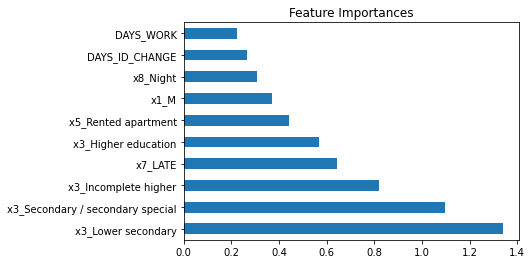

<Figure size 1296x720 with 0 Axes>

In [91]:
# Find the coefficient of the model
importance = logreg_best.coef_[0]

# Plot barchart
feat_importances = pd.Series(importance, index=X_train_DF.columns)
feat_importances.nlargest(10).plot(kind='barh', title = 'Feature Importances')

plt.figure(figsize=(18,10))

plt.show()

**EXPLANATION**
We can see that the top features that have high importance to our model are from EDUCATION column, followed by PAYMENT BEHAVIOUR, HOUSING TYPE, GENDER, etc.
In this chart we cannot define whether how the features affect our model (whether if the values are low or high), that is why we will use SHAP to check the relation.

## SHAP

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1000 [00:00<?, ?it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s i

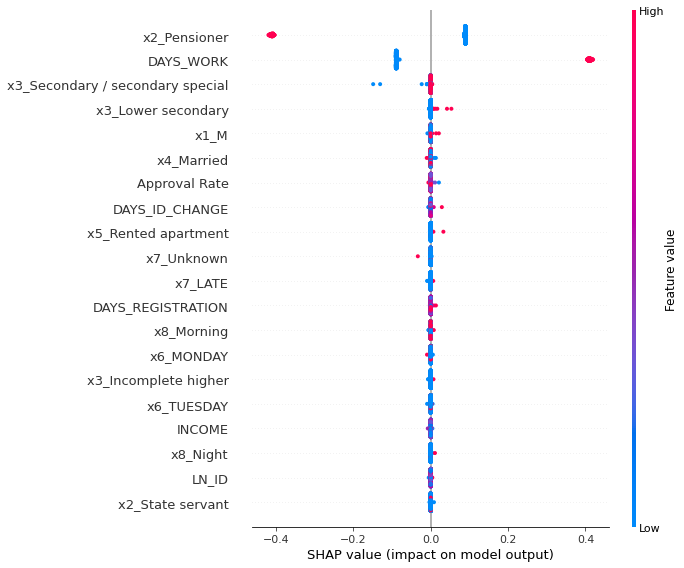

In [92]:
# Define model
model_shap = logreg_best.fit(X_train_DF, y_train)

# Define explainer (we only use sampling because of the huge amount of data)
explainer = shap.KernelExplainer(model_shap.predict, shap.sample(X_train_DF, 1000))

# Calculate the SHAP value
shap_val = explainer.shap_values(shap.sample(X_train_DF, 1000))

# Plot
shap.summary_plot(shap_val, shap.sample(X_train_DF, 1000))

**EXPLANATION**
- To read the chart we see the color first if it is red then the value of the specific feature is high, if it is blue then it is low. 
- We also see whether the point is on the right side or the left side, if it is on the right, then it have positive influence on the model, if it is on the left it have negative influence on the model

- A bit different from the feature importance, the top feature is whether the customer is a pensioner or not (if it is then it will have negative impact on the model).
- We can also see that the higher the days of work the more positive it have on our model